In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os
import pandas as pd

In [2]:
path = "/media/scilab/disk_ranjan/works/westcoast_adcp1/backscatternew/7adcp_biomass/"
files = sorted([f for f in os.listdir(path) if f.endswith(".nc")])
ds = [xr.open_dataset(path+files[i]) for i in range(7)]

In [24]:
dsd = [e.resample(TIME='24h').mean() for e in ds]

In [25]:
angles = xr.open_dataset("/media/scilab/disk_ranjan/works/westcoast_adcp1/backscatternew/8process/rotated_current/angle/angle_25.nc")

In [26]:
df = pd.read_csv("/media/scilab/disk_ranjan/works/westcoast_adcp1/backscatternew/8process/rotated_current/angle/angles.csv")

In [27]:
data = np.random.rand(20, 5)

In [28]:
import numpy as np
from sklearn.decomposition import PCA

def calculate_pca_angles(U, V):
    """
    Calculate the PCA angle for each depth.
    
    Parameters:
    - U: 2D NumPy array of U component (time x depth)
    - V: 2D NumPy array of V component (time x depth)
    
    Returns:
    - angles: 1D array of PCA angles for each depth
    """
    n_depths = U.shape[1]
    angles = np.full(n_depths, np.nan)  # Initialize with NaNs

    for depth in range(n_depths):
        # Extract the U and V components for the current depth
        u_depth = U[:, depth]
        v_depth = V[:, depth]
        
        # Remove NaNs
        valid_mask = ~np.isnan(u_depth) & ~np.isnan(v_depth)
        u_valid = u_depth[valid_mask]
        v_valid = v_depth[valid_mask]
        
        if len(u_valid) > 1:
            # Stack U and V for PCA
            data = np.stack((u_valid, v_valid), axis=1)
            
            # Perform PCA
            pca = PCA(n_components=2)
            pca.fit(data)
            
            # Get the principal component (the first eigenvector)
            principal_component = pca.components_[0]
            
            # Calculate the angle in radians with respect to the U axis
            angle_radians = np.arctan2(principal_component[1], principal_component[0])
            
            # Convert angle to degrees
            angle_degrees = np.degrees(angle_radians)

            angle_degrees1 = (angle_degrees + 180) % 360   # change to 0 to 360
            angle_degrees2 = (angle_degrees1 + 90) % 360  # change to north as +ve
            angle_degrees3 = np.where(angle_degrees2 > 180,angle_degrees2-180,angle_degrees2) # change to supplementary angles for anything above 180
            # Store the angle
            
            angles[depth] = angle_degrees3
            
    return angles


In [29]:
def rotate_currents_to_cross_shore_alongshore(U, V, pca_angles):
    """
    Rotate the U and V currents to cross-shore and alongshore coordinates using PCA angles.
    
    Parameters:
    - U: 2D NumPy array of U component (time x depth)
    - V: 2D NumPy array of V component (time x depth)
    - pca_angles: 1D array of PCA angles for each depth (from -180 to 180)
    
    Returns:
    - U_cross_shore: 2D NumPy array of cross-shore components
    - V_cross_shore: 2D NumPy array of alongshore components
    """
    n_times, n_depths = U.shape
    U_cross_shore = np.full_like(U, np.nan)
    V_cross_shore = np.full_like(V, np.nan)

    # Convert PCA angles to [0, 360) range
    converted_angles = pca_angles

    # Convert angles to radians
    angles_radians = np.radians(converted_angles)

    for depth in range(n_depths):
        # Extract the U and V components for the current depth
        u_depth = U[:, depth]
        v_depth = V[:, depth]
        
        # Remove NaNs
        valid_mask = ~np.isnan(u_depth) & ~np.isnan(v_depth)
        u_valid = u_depth[valid_mask]
        v_valid = v_depth[valid_mask]
        
        if len(u_valid) > 1:
            # Construct the rotation matrix for the current depth
            cos_theta = np.cos(angles_radians[depth])
            sin_theta = np.sin(angles_radians[depth])
            rotation_matrix = np.array([
                [cos_theta, -sin_theta],
                [sin_theta, cos_theta]
            ])
            
            # Stack U and V for rotation
            currents = np.stack((u_valid, v_valid), axis=1)
            
            # Apply the rotation matrix
            rotated_currents = currents.dot(rotation_matrix.T)
            
            # Store the rotated components
            U_cross_shore[valid_mask, depth] = rotated_currents[:, 0]
            V_cross_shore[valid_mask, depth] = rotated_currents[:, 1]

    return U_cross_shore, V_cross_shore



In [30]:
u1 = dsd[2].U1[:,5:31,0,0].values
v1 = dsd[1].V1[:,5:31,0,0].values
pca_angle = calculate_pca_angles(u1,v1)
a,c = rotate_currents_to_cross_shore_alongshore(u1,v1,pca_angle)

In [34]:
for i in range(7):
    u1 = dsd[i].U1[:,:,0,0]
    v1 = dsd[i].V1[:,:,0,0]
    pca_angle =  calculate_pca_angles(u,v)
    cross,along = rotate_currents_to_cross_shore_alongshore(u1,v1,pca_angle)
    
    u2 = xr.DataArray(
        data=u1,
        dims=["time","depth"],
        coords={'time':dsd[i].TIME.values,'depth':dsd[i].DEPTH1.values}
    )
    v2 = xr.DataArray(
        data=v1,
        dims=["time","depth"],
        coords={'time':dsd[i].TIME.values,'depth':dsd[i].DEPTH1.values}
    )
    cross1 = xr.DataArray(
        data=cross,
        dims=["time","depth"],
        coords={'time':dsd[i].TIME.values,'depth':dsd[i].DEPTH1.values}
    )
    along1 = xr.DataArray(
        data=along,
        dims=["time","depth"],
        coords={'time':dsd[i].TIME.values,'depth':dsd[i].DEPTH1.values}
    )
    
    dsnew = xr.Dataset({
        "uraw":u2,
        "vraw":v2,
        "cross":cross1,
        "along":along1
    },{"author":"ranjan"})
    dsnew.to_netcdf("/media/scilab/disk_ranjan/works/westcoast_adcp1/backscatternew/8process/rotated_current/rot_"+files[i])
    

In [ ]:
dsd[0]

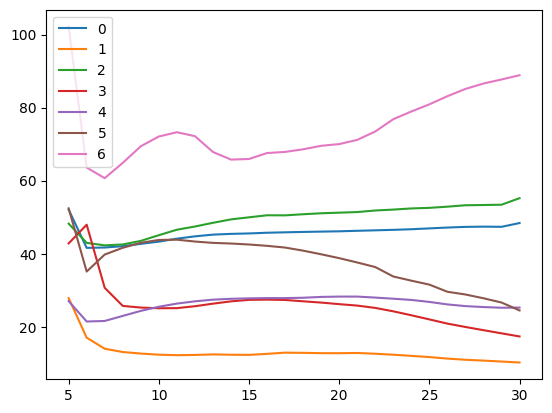

In [32]:
for i in range(7):
    u1 = dsd[i].U1[:,5:31,0,0].values
    v1 = dsd[i].V1[:,5:31,0,0].values
    angle =  calculate_pca_angles(u1,v1)
    plt.plot(np.arange(5,31),angle,label=i)
plt.legend()

NameError: name 'lev' is not defined

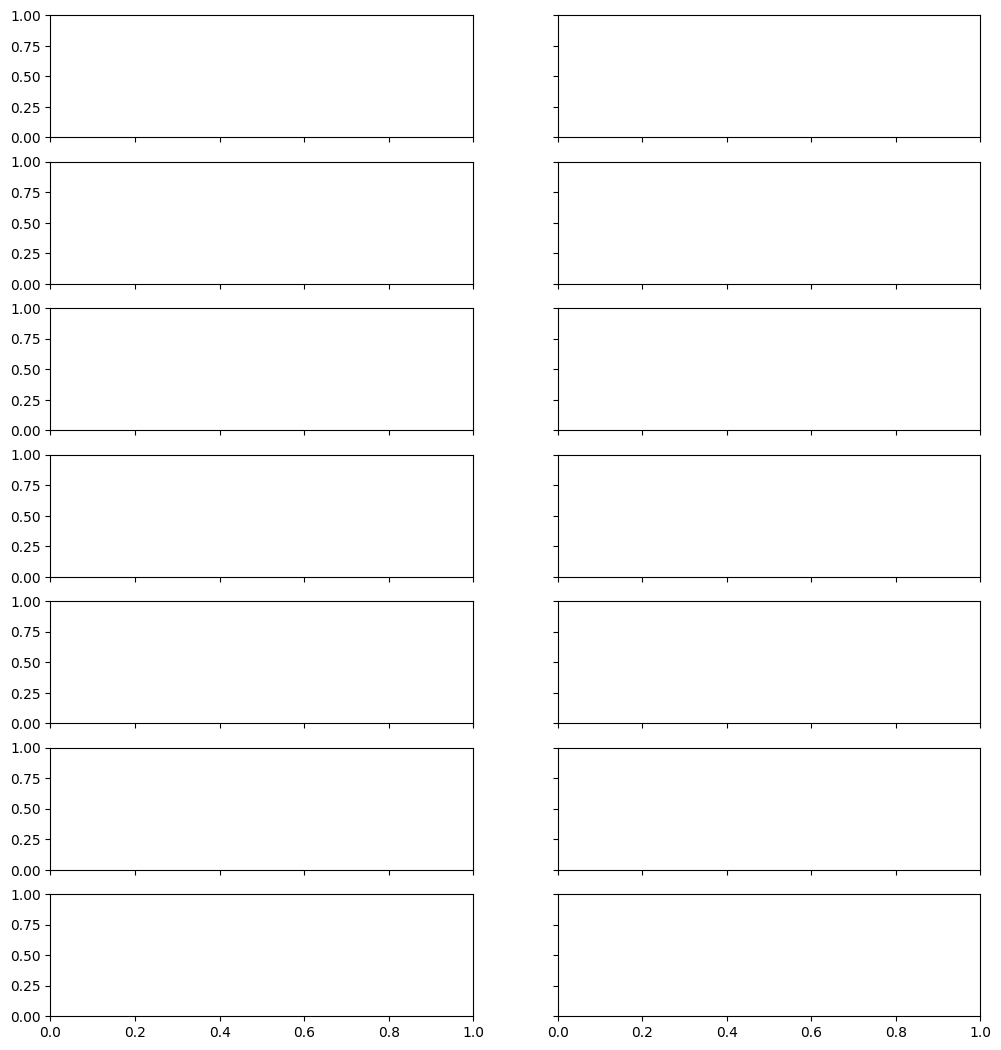

In [33]:
fig,ax = plt.subplots(nrows=7,ncols=2,figsize=(12,13),sharex=True,sharey=True)

for i in range(7):
    u1 = dsd[i].U1[:,:,0,0].values
    v1 = dsd[i].V1[:,:,0,0].values
    pca_angle =  calculate_pca_angles(u1,v1)
    cross,along = rotate_currents_to_cross_shore_alongshore(u1,v1,pca_angle)
    figcol= ax[i,0].contourf(dsd[i].TIME,dsd[i].DEPTH1[:],u1[:,:].T,cmap="bwr",levels=lev,extend="both")
    ax[i,1].contourf(dsd[i].TIME,dsd[i].DEPTH1[:],v1[:,:].T,cmap="bwr",levels=lev,extend="both")


    ang_rad =   np.deg2rad(df.angle[i])
#    ang_rad = np.deg2rad(angnew[20])
    cross1 =   u1 * np.cos(ang_rad) - v1 * np.sin(ang_rad)
    along1 =   u1 * np.sin(ang_rad) + v1 * np.cos(ang_rad)
    ax[i,1].contourf(dsd[i].TIME,dsd[i].DEPTH1[:],u1[:,:].T,cmap="turbo",levels=np.arange(-30,30,5),extend="both")

    ax[0,0].set_ylim(ymin=0,ymax=120)
    ax[0,0].invert_yaxis()
cax = fig.add_axes([0.05, 0.04, 0.9,0.0125])
cbar = fig.colorbar(figcol, cax=cax, orientation="horizontal",)
    

In [ ]:
path = "/media/scilab/disk_ranjan/works/westcoast_adcp1/backscatternew/8process/lancos_filter/intraseasonal_currents/"
files = sorted([f for f in os.listdir(path) if f.endswith(".nc")])
ds = [xr.open_dataset(path+files[i]) for i in range(7)]

In [ ]:
lev = [-40,-20,-10,-5,0,5,10,20,40]

In [ ]:
fig,ax = plt.subplots(nrows=7,ncols=2,figsize=(12,13),sharex=True,sharey=True)

for i in range(7):
    u1 = ds[i].INTAN_U[:,:,0,0].values
    v1 = ds[i].INTAN_V[:,:,0,0].values
    figcol= ax[i,0].contourf(ds[i].AX006,dsd[i].DEPTH1[:],u1[:,:].T,cmap="bwr",levels=lev,extend="both")
    ax[i,1].contourf(ds[i].AX006,dsd[i].DEPTH1[:],v1[:,:].T,cmap="bwr",levels=lev,extend="both")
    ax[i,0].invert_yaxis()
cax = fig.add_axes([0.05, 0.04, 0.9,0.0125])
cbar = fig.colorbar(figcol, cax=cax, orientation="horizontal",)
    